# Fitting BOLD signals

Download the Jupyter notebook: [BoldSearch.ipynb](https://raw.githubusercontent.com/ANNarchy/CNS2023/master/src/notebooks/BoldSearch.ipynb){target="_blank"} or run it directly on  [colab.](https://colab.research.google.com/github/ANNarchy/CNS2023/blob/master/src/notebooks/BoldSearch.ipynb){target="_blank"}

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ANNarchy import *
from ANNarchy.extensions.bold import *
clear()

ANNarchy 4.7 (4.7.2.5) on darwin (posix).


We will now use the BOLD monitor to find the hyperparameters of a model that explains the best some recorded BOLD signals. 

These hyperparameters can be anything: time constants, synaptic strengths, number of neurons, etc. 

With a fixed set of values for the hyperparameters, one can create a network, run a simulation comparable to the experiment, monitor the BOLD signal and "match" it with the recorded BOLD data.

Using some optimization algorithm (grid/random search, genetic algorithms, Bayesian surrogate optimization), one can then find which set of hyperparameters matches the most with the data.

In this notebook, we use Bayesian surrogate optimization with the `hyperopt` library, but any other gradient-free method could be used (optuna is a good alternative to hyperopt):

https://hyperopt.github.io

In [3]:
#!pip install hyperopt

In [4]:
import hyperopt as ho

In order to keep the simulation short, we demonstrate here the method using a dummy problem, i.e. our 100 Izhikevich neurons from the last notebooks, and search for which noise level do the min and max values of the BOLD signal get a desired value.

To do so, we need to implement a method that runs a simulation for a given value of the parameters, records the BOLD signal and return how well it matches with the desired profile. We use here a simple Euclidian loss:

In [5]:
def trial(params):

    clear()

    # One populations of 100 izhikevich neurons
    pop = Population(100, neuron=Izhikevich)

    # Set noise to create some baseline activity
    pop.noise = 5.0

    # Compute mean firing rate in Hz on 100ms window
    pop.compute_firing_rate(window=100.0)

    m_bold = BoldMonitor(
        
        populations = pop, # recorded population
        
        bold_model = balloon_RN(), # BOLD model to use (default is balloon_RN)
        
        mapping = {'I_CBF': 'r'}, # mapping from pop.r to I_CBF
        
        normalize_input = 2000,  # time window to compute baseline.
        
        recorded_variables = ["I_CBF", "BOLD"]  # variables to be recorded in the BOLD model
    )

    compile()

    # Warm-up
    simulate(2000)
    m_bold.start()

    # We manipulate the noise for the half of the neurons
    simulate(5000)      # 5s with low noise
    pop.noise = params[0]
    simulate(5000)      # 500ms with higher noise (one population)
    pop.noise = 5.0
    simulate(20000)     # 20s with low noise

    # Retrieve the recordings
    input_data = m_bold.get("I_CBF")
    bold_data = m_bold.get("BOLD")

    # Compute the loss
    loss = (bold_data.max() - 0.05)**2 + (bold_data.min() + 0.02)**2

    return {
        'loss': loss,
        'status': ho.STATUS_OK,
        # -- store other results like this
        'input_data': input_data,
        'bold_data': bold_data,
        }

If we run this method with a noise level of 7.5, we get the same results:

Compiling ...  OK 


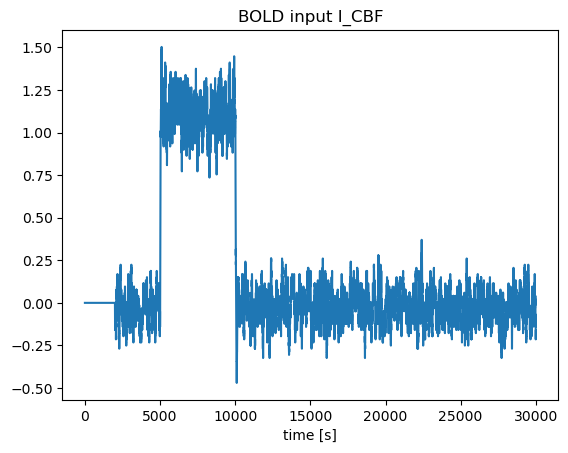

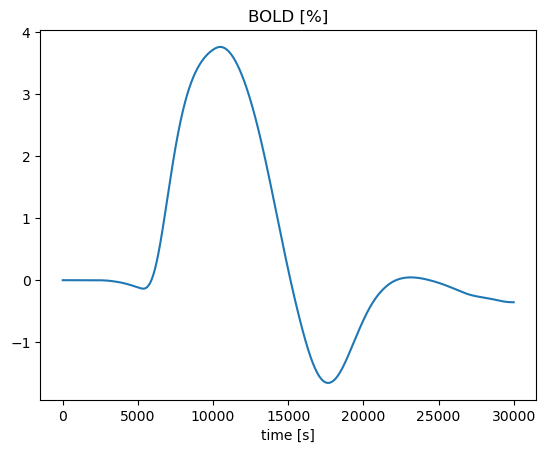

In [6]:
data = trial([7.5])

# BOLD input signal
plt.figure()
plt.plot(data['input_data'])
plt.title("BOLD input I_CBF")
plt.xlabel("time [s]")

# BOLD output signal
plt.figure()
plt.plot(data['bold_data']*100.0)
plt.title("BOLD [%]")
plt.xlabel("time [s]")

plt.show()

Let's now run the hyperparameter optimization to minimize the loss function, defined as the Euclidian distance between the minimum and maximum values of the BOLD signal, and (5 %, 2 %)...

```python
loss = (bold_data.max() - 0.05)**2 + (bold_data.min() + 0.02)**2
```

`hyperopt.fmin` will run 200 trials using different values of the noise between 5 and 15, computing the loss everytime and finding wich value minimizes the loss.

In [7]:
best = ho.fmin(
    fn=trial,
    space=[
        ho.hp.uniform('noise', 5.0, 15.0), 
    ],
    algo=ho.tpe.suggest,
    max_evals=200
)

print(best)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 200/200 [01:14<00:00,  2.67trial/s, best loss: 3.165198988002009e-07]
{'noise': 9.641243776203385}


We can now check that the obtained hyperparameters indeed do what we want.

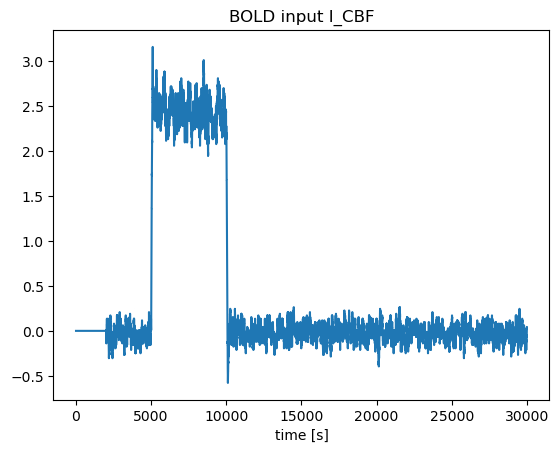

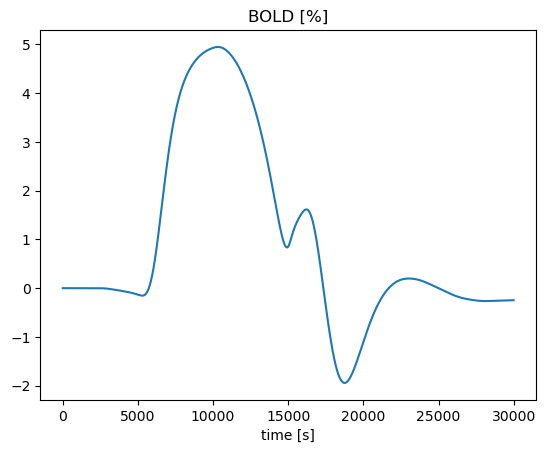

In [8]:
data = trial(list(best.values()))

# BOLD input signal
plt.figure()
plt.plot(data['input_data'])
plt.title("BOLD input I_CBF")
plt.xlabel("time [s]")

# BOLD output signal
plt.figure()
plt.plot(data['bold_data']*100.0)
plt.title("BOLD [%]")
plt.xlabel("time [s]")

plt.show()

**Experiments:**

1. Define more complex criteria (min/max, temporal gap between min and max, fit to data, etc) and rerun the hyperoptimization.
2. Create a more complex network and run the optimization on more hyperparameters.